In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load the tweets dataframe
tweets_df = pd.read_pickle(r'C:\Users\20232788\Desktop\DBL-1\complete_sentences_emb\tweets_df2.pkl')

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment
def calculate_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    if sentiment['compound'] >= 0.05:
        return 'Positive'
    elif sentiment['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Calculate sentiment for each tweet
tweets_df['sentiment'] = tweets_df['text'].apply(calculate_sentiment)

# Define the list of topics
topics_list = ['Flight Cancellation/Refounds', 'Customer Services', 'Inclusivity/Racism', 
               'Onboard Services', 'Destination', 'Food', 'Online Booking', 
               'Easyjet Franchise', 'Oguna/Lufthansa scandal', 'Health Issues']

# Define the airlines and their tags as a list
airline_tags = {
    'easyJet': ['easyjet'],
    'British Airways': ['british airways', 'british_airways', 'britishairways'],
    'RyanAir': ['ryanair']
}

# Loop through each airline and plot the sentiment analysis
for airline, tags in airline_tags.items():
    # Filter tweets that mention any of the current airline's tags
    pattern = '|'.join(tags)  # Creates a regex pattern to match any of the tags
    airline_tweets = tweets_df[tweets_df['text'].str.contains(pattern, case=False, regex=True)]
    
    # Group by topic and sentiment
    grouped = airline_tweets.groupby(['topic', 'sentiment']).size().reset_index(name='count')

    # Filter only known topics
    grouped = grouped[grouped['topic'].isin(topics_list)]

    # Plot sentiment analysis per topic for each airline
    plt.figure(figsize=(15, 8))
    sns.barplot(data=grouped, x='topic', y='count', hue='sentiment', palette='Set2')
    plt.title(f'Sentiment Analysis for {airline} Tweets per Topic')
    plt.xlabel('Topic')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Sentiment')
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f'{airline}_sentiment_analysisss.png')
    plt.close()  # Close the figure to free up memory


C:\Users\20232788\AppData\Local\Temp\ipykernel_3760\2350108805.py:87: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='topic', y='initial_sentiment', hue='airline', ci=None)


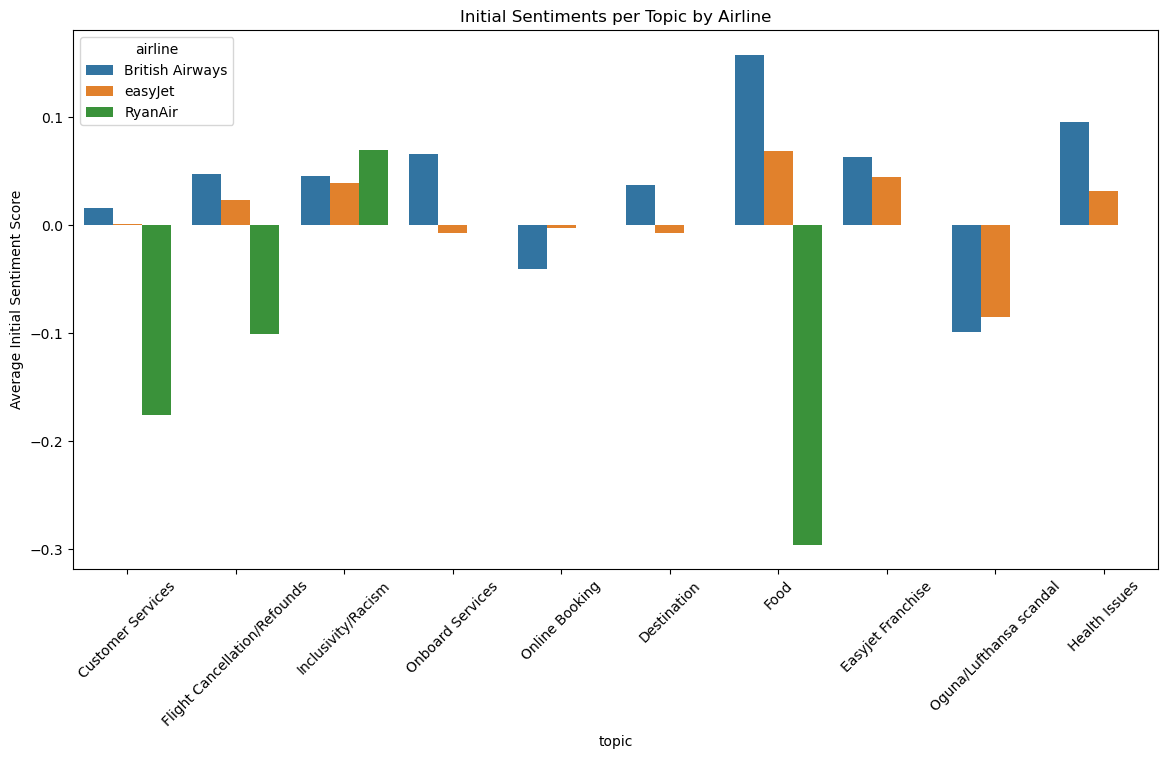

C:\Users\20232788\AppData\Local\Temp\ipykernel_3760\2350108805.py:95: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='topic', y='sentiment_change', hue='airline', ci=None)


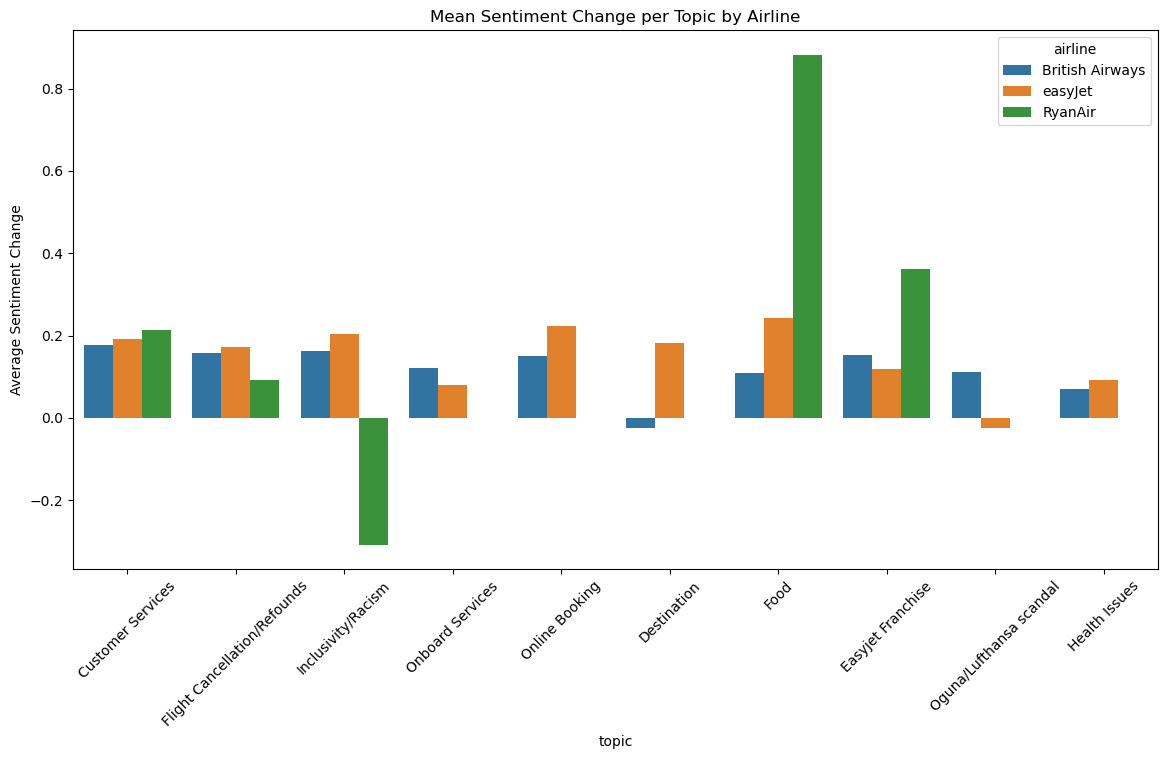

In [2]:
import sqlite3
import json
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to the SQLite database
conn = sqlite3.connect(r"C:\Users\20232788\Downloads\conversations_2.db")
cursor = conn.cursor()

# Define airline handles with multiple tags
airline_handles = {
    'easyJet': ['easyjet', '@easyJet'],
    'British Airways': ['britishAirways', 'British_Airways', 'britishairways'],
    'RyanAir': ['ryanair']
}

# Query filtered conversations
query = """
SELECT conversation_id, conversation_json, topic 
FROM filtered_conversations
"""
cursor.execute(query)
raw_conversations = cursor.fetchall()

# Initialize sentiment analyzer

# Data structure to store results
data = []

# Function to determine airline based on text
def find_airline(text):
    for airline, tags in airline_handles.items():
        for tag in tags:
            if tag in text:
                return airline
    return None

# Process each conversation
for convo_id, json_str, topic in raw_conversations:
    convo = json.loads(json_str)
    conversation_sentiments = []
    
    for i, message in enumerate(convo):
        text = message['text']
        sentiment_score = analyzer.polarity_scores(text)['compound']
        conversation_sentiments.append(sentiment_score)
        
        # Determine airline
        airline = find_airline(text)
        
        # Append data for analysis
        data.append({
            'conversation_id': convo_id,
            'tweet_id': message['id_str'],
            'user_type': 'airline' if i % 2 != 0 else 'user',
            'text': text,
            'sentiment': sentiment_score,
            'airline': airline,
            'topic': topic
        })
        
    # Calculate initial and final sentiments for conversations longer than 1
    if len(conversation_sentiments) > 1:
        initial_sentiment = conversation_sentiments[0]
        final_sentiment = conversation_sentiments[-1]
        sentiment_change = final_sentiment - initial_sentiment
        data.append({
            'conversation_id': convo_id,
            'sentiment_change': sentiment_change,
            'initial_sentiment': initial_sentiment,
            'final_sentiment': final_sentiment,
            'topic': topic,
            'airline': airline
        })

# Create DataFrame from the collected data
df = pd.DataFrame(data)

# Close the cursor and connection
cursor.close()
conn.close()



# Plot sentiment changes per topic for each airline
plt.figure(figsize=(14, 7))
sns.barplot(data=df, x='topic', y='sentiment_change', hue='airline', ci=None)
plt.title('Mean Sentiment Change per Topic by Airline')
plt.ylabel('Average Sentiment Change')
plt.xticks(rotation=45)
plt.show()


C:\Users\20232788\AppData\Local\Temp\ipykernel_3348\1790089206.py:100: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='topic', y='sentiment_change', hue='airline', ci=None)


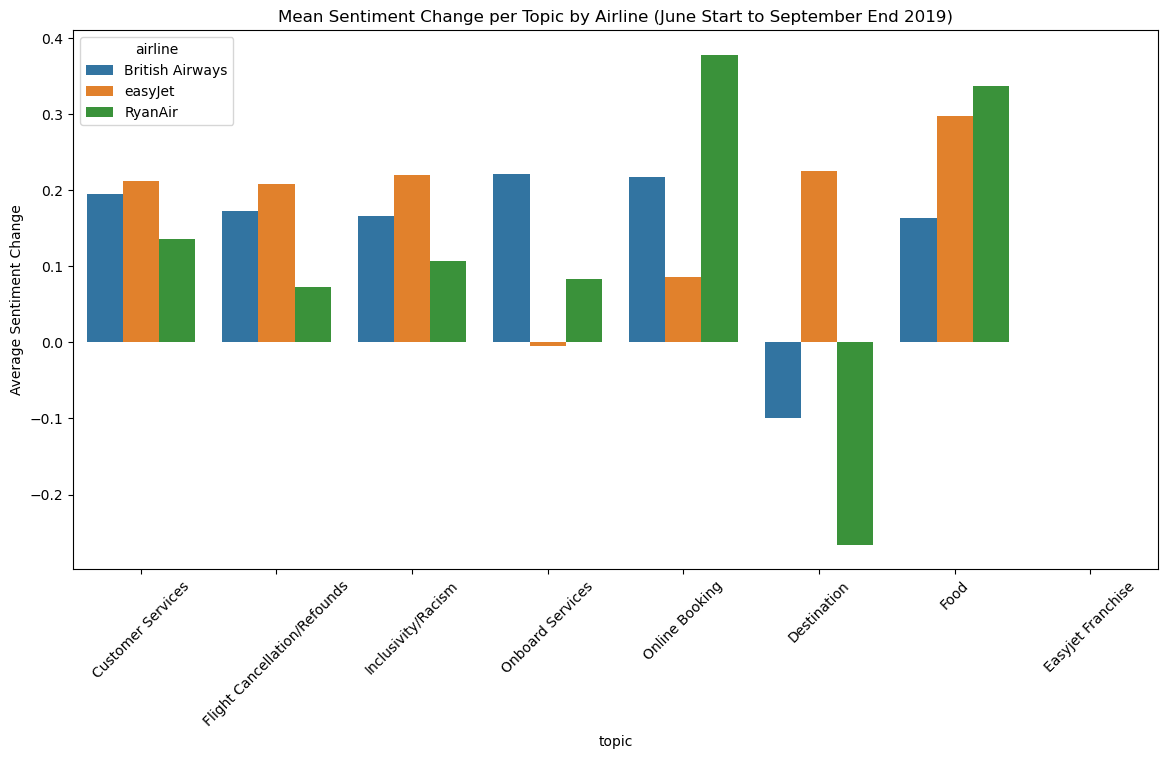

In [1]:
import sqlite3
import json
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to the SQLite database
conn = sqlite3.connect(r"C:\Users\20232788\Downloads\conversations_2.db")
cursor = conn.cursor()

# Define airline handles with multiple tags
airline_handles = {
    'easyJet': ['@easyjet', '@EasyJet'],
    'British Airways': ['@BritishAirways', '@British_Airways', '@britishairways'],
    'RyanAir': ['@ryanair']
}

# Query filtered conversations
query = """
SELECT conversation_id, conversation_json, topic 
FROM filtered_conversations
"""
cursor.execute(query)
raw_conversations = cursor.fetchall()

# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Data structure to store results
data = []

# Define the date range
start_date = pd.Timestamp('2019-05-01').tz_localize('US/Eastern')
end_date = pd.Timestamp('2019-08-30').tz_localize('US/Eastern')

# Function to determine airline based on text
def find_airline(text):
    for airline, tags in airline_handles.items():
        for tag in tags:
            if tag.lower() in text.lower():
                return airline
    return None

# Process each conversation
for convo_id, json_str, topic in raw_conversations:
    convo = json.loads(json_str)
    conversation_sentiments = []
    
    for i, message in enumerate(convo):
        text = message['text']
        timestamp = pd.to_datetime(message['created_at'])
        
        # Check if the timestamp is within the desired range
        if not (start_date <= timestamp <= end_date):
            continue

        sentiment_score = analyzer.polarity_scores(text)['compound']
        conversation_sentiments.append(sentiment_score)
        
        # Determine airline
        airline = find_airline(text)
        
        # Append data for analysis
        data.append({
            'conversation_id': convo_id,
            'tweet_id': message['id_str'],
            'user_type': 'airline' if i % 2 != 0 else 'user',
            'text': text,
            'sentiment': sentiment_score,
            'airline': airline,
            'topic': topic,
            'timestamp': timestamp
        })
        
    # Calculate initial and final sentiments for conversations longer than 1
    if len(conversation_sentiments) > 1:
        initial_sentiment = conversation_sentiments[0]
        final_sentiment = conversation_sentiments[-1]
        sentiment_change = final_sentiment - initial_sentiment
        data.append({
            'conversation_id': convo_id,
            'sentiment_change': sentiment_change,
            'initial_sentiment': initial_sentiment,
            'final_sentiment': final_sentiment,
            'topic': topic,
            'airline': airline
        })

# Create DataFrame from the collected data
df = pd.DataFrame(data)

# Close the cursor and connection
cursor.close()
conn.close()


# Plot sentiment changes per topic for each airline
plt.figure(figsize=(14, 7))
sns.barplot(data=df, x='topic', y='sentiment_change', hue='airline', ci=None)
plt.title('Mean Sentiment Change per Topic by Airline (June Start to September End 2019)')
plt.ylabel('Average Sentiment Change')
plt.xticks(rotation=45)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

conn = sqlite3.connect(r"C:\Users\20232788\Downloads\tweets4.db")

# Define your query
query = "SELECT id_str, text, created_at, user_id_str, topic FROM tweets"

# Execute the query and load the results into a DataFrame
tweets_df = pd.read_sql_query(query, conn)

conn.close()

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Convert 'created_at' to datetime
tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'])

# Define the time range
start_date = '2019-05-01'
end_date = '2019-08-30'

# Filter tweets within the timeframe
tweets_df = tweets_df[(tweets_df['created_at'] >= start_date) & (tweets_df['created_at'] <= end_date)]

# Function to calculate sentiment
def calculate_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    if sentiment['compound'] >= 0.05:
        return 'Positive'
    elif sentiment['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Calculate sentiment for each tweet
tweets_df['sentiment'] = tweets_df['text'].apply(calculate_sentiment)

# Define the list of topics
topics_list = ['Flight Cancellation/Refounds', 'Customer Services', 'Inclusivity/Racism', 
               'Onboard Services', 'Destination', 'Food', 'Online Booking', 
               'Easyjet Franchise', 'Oguna/Lufthansa scandal', 'Health Issues']

# Define the airlines and their tags as a list
airline_tags = {
    'easyJet': ['easyjet'],
    'British Airways': ['british airways', 'british_airways', 'britishairways'],
    'RyanAir': ['ryanair']
}

# Loop through each airline and plot the sentiment analysis
for airline, tags in airline_tags.items():
    # Filter tweets that mention any of the current airline's tags
    pattern = '|'.join(tags)  # Creates a regex pattern to match any of the tags
    airline_tweets = tweets_df[tweets_df['text'].str.contains(pattern, case=False, regex=True)]
    
    # Group by topic and sentiment
    grouped = airline_tweets.groupby(['topic', 'sentiment']).size().reset_index(name='count')

    # Filter only known topics
    grouped = grouped[grouped['topic'].isin(topics_list)]

    # Plot sentiment analysis per topic for each airline
    plt.figure(figsize=(15, 8))
    sns.barplot(data=grouped, x='topic', y='count', hue='sentiment', palette='Set2')
    plt.title(f'Sentiment Analysis for {airline} Tweets per Topic (June to September 2019)')
    plt.xlabel('Topic')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Sentiment')
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f'{airline}DEMO_IMagessentiment_analysis{start_date}to{end_date}.png')
    plt.close()  # Close the figure to free up memory

C:\Users\20232788\AppData\Local\Temp\ipykernel_3348\4281460432.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'])
